Step: step00


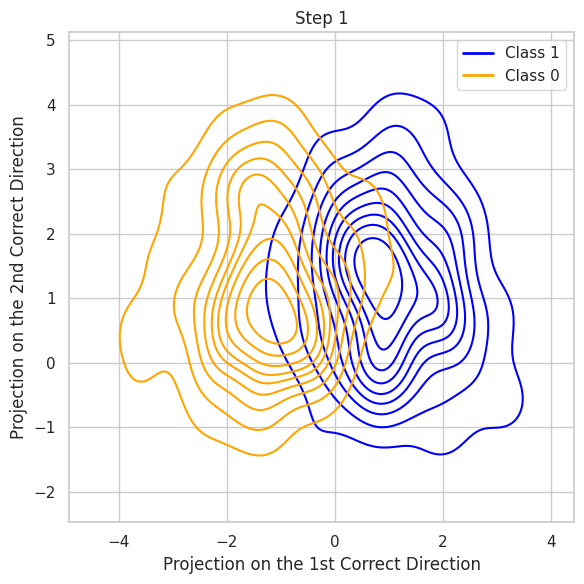

Step: step01


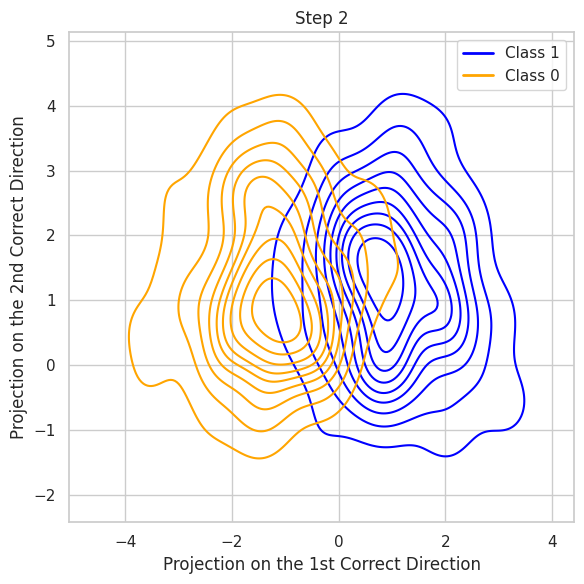

Step: step02


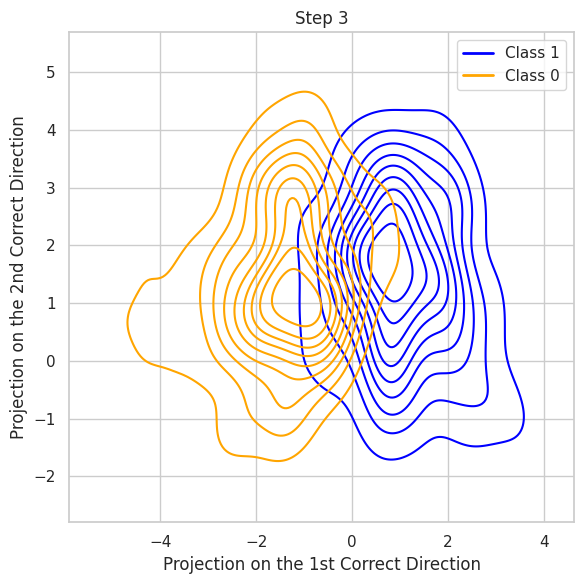

Step: step03


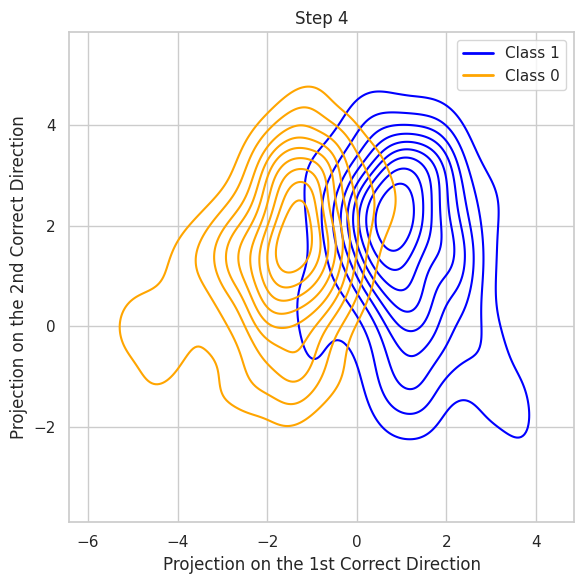

Step: step04


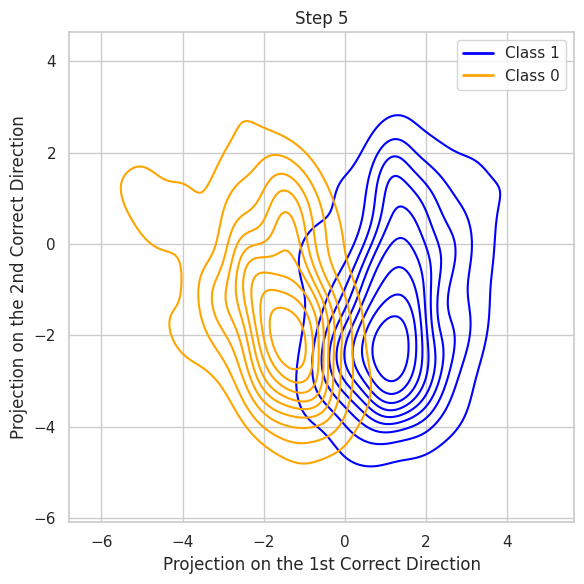

Step: step05


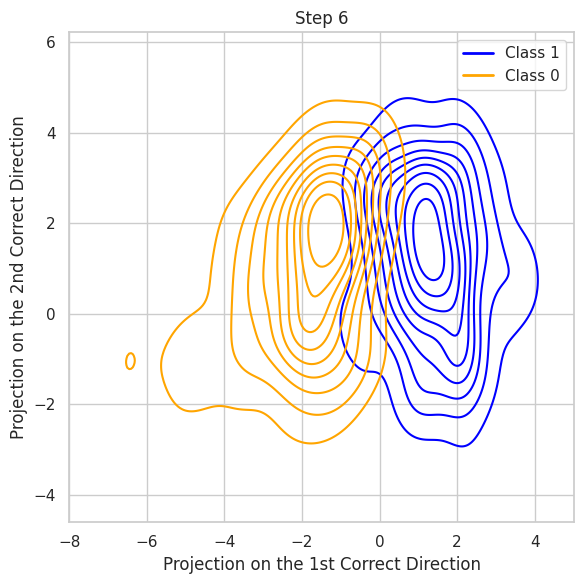

Step: step06


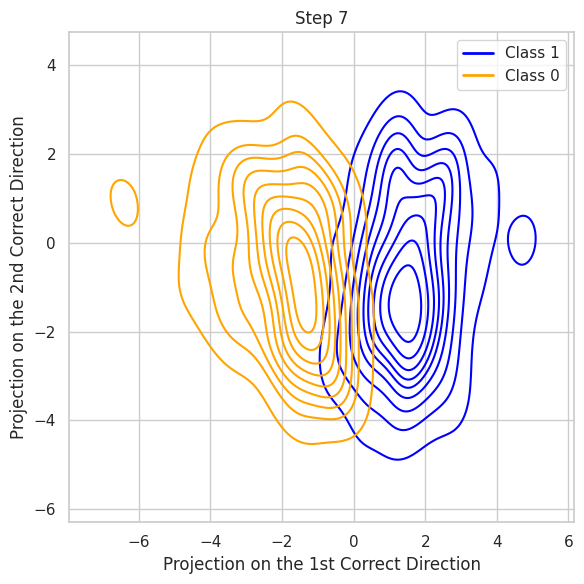

Step: step07


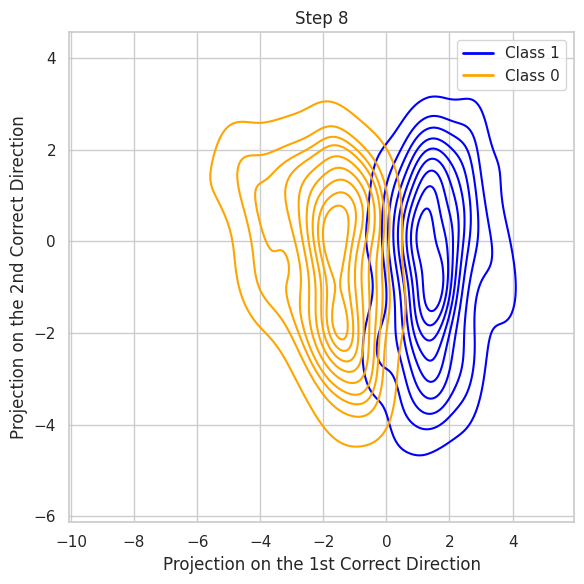

Step: step08


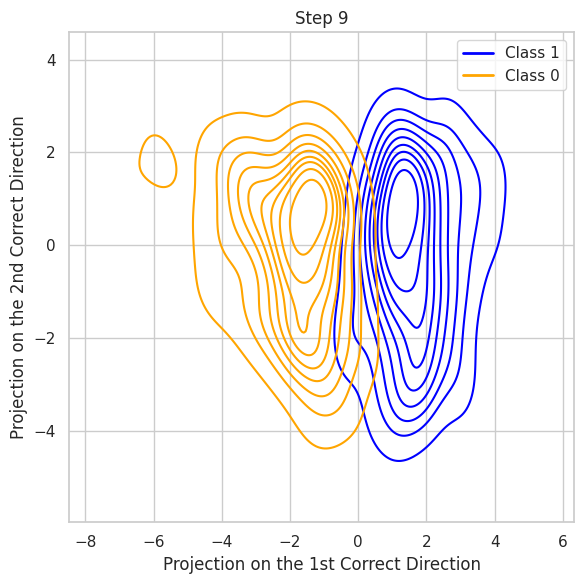

Step: step09


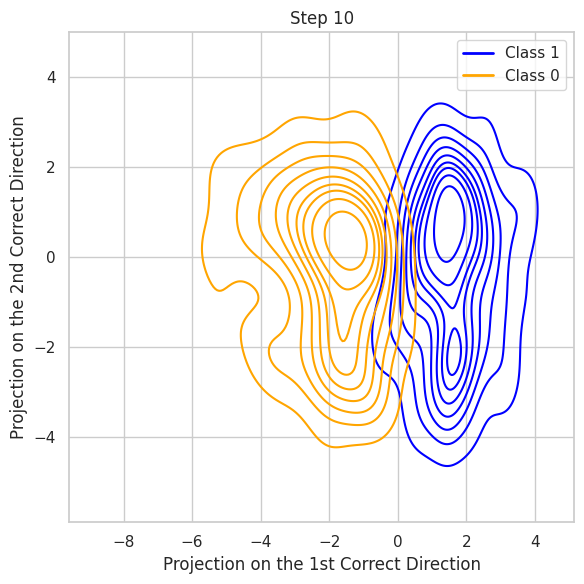

In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from collections import defaultdict
from matplotlib.lines import Line2D  

excel_path = "../steering_vector_dataset.xlsx"
base_npy_dir = "../final_npys"
steps = [f"step{str(i).zfill(2)}" for i in range(10)]

# 1. 라벨 로드
df = pd.read_excel(excel_path)
df["prompt_key"] = df["prompt"].str.replace(" ", "_")

for step in steps:
    print(f"Step: {step}")
    npy_dir = os.path.join(base_npy_dir, step)

    X, y = [], []

    for _, row in df.iterrows():
        npy_path = os.path.join(npy_dir, row["prompt_key"] + f"_{step}.npy")
        if not os.path.exists(npy_path):
            continue

        data = np.load(npy_path, allow_pickle=True).item()
        flat_vecs = []
        for k, v in data["query"].items():
            if v.ndim == 3:
                vec = v.mean(axis=(0, 1))
                flat_vecs.append(vec)

        if flat_vecs:
            group_by_dim = defaultdict(list)
            for vec in flat_vecs:
                group_by_dim[vec.shape[0]].append(vec)
            most_common_dim = max(group_by_dim, key=lambda k: len(group_by_dim[k]))
            mean_vec = np.mean(group_by_dim[most_common_dim], axis=0)
            X.append(mean_vec)
            y.append(row["label"])

    if not X:
        print(f"No vectors for step {step}")
        continue

    X = np.stack(X)
    y = np.array(y)

    # 2. Truthful direction 구하기
    clf = LogisticRegression().fit(X, y)
    direction_1 = clf.coef_[0]

    # 3. PCA 기반 orthogonal direction
    X_proj = X - (X @ direction_1)[:, None] * direction_1 / (np.linalg.norm(direction_1) + 1e-8)**2
    direction_2 = PCA(n_components=1).fit(X_proj).components_[0]

    # 4. 투영
    proj_x = X @ direction_1
    proj_y = X @ direction_2

    # 5. 시각화 (선 스타일 KDE plot)
    plt.figure(figsize=(6, 6))
    sns.set(style="whitegrid")

    sns.kdeplot(x=proj_x[y == 1], y=proj_y[y == 1], color="blue", fill=False)
    sns.kdeplot(x=proj_x[y == 0], y=proj_y[y == 0], color="orange", fill=False)

    custom_lines = [
        Line2D([0], [0], color="blue", lw=2, label="Class 1"),
        Line2D([0], [0], color="orange", lw=2, label="Class 0")
    ]
    plt.legend(handles=custom_lines)

    plt.xlabel("Projection on the 1st Correct Direction")
    plt.ylabel("Projection on the 2nd Correct Direction")
    step_num = int(step[-2:]) + 1  # step00 → 1, step09 → 10
    plt.title(f"Step {step_num}")
    plt.tight_layout()
    plt.show()
    plt.close()